To-Do List:
- Preprocessing: Tokenization, Lemmatization, Stopword removal
- Represent the Text: TF-IDF, Word2Vec or Bert
- Models: SVM or LSTM
- Evaluation: Precision, Recall, F1

# SENTIMENT ANALYSIS TASK ON TWITS

## Exploratory Data Analysis

Firstly, we import the movie review dataset and the necessary libraries.

In [1]:
import pandas as pd
import kagglehub
from kagglehub import KaggleDatasetAdapter

file_path = "cyberbullying_tweets.csv"

df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "andrewmvd/cyberbullying-classification",
  file_path,
)

print("First 5 records:", df.head())

/tmp/ipykernel_35/1788085761.py:7: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


First 5 records:                                           tweet_text cyberbullying_type
0  In other words #katandandre, your food was cra...  not_cyberbullying
1  Why is #aussietv so white? #MKR #theblock #ImA...  not_cyberbullying
2  @XochitlSuckkks a classy whore? Or more red ve...  not_cyberbullying
3  @Jason_Gio meh. :P  thanks for the heads up, b...  not_cyberbullying
4  @RudhoeEnglish This is an ISIS account pretend...  not_cyberbullying


We visualize the first 10 entries in our dataset.

In [2]:
df.head(10)

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying
5,"@Raja5aab @Quickieleaks Yes, the test of god i...",not_cyberbullying
6,Itu sekolah ya bukan tempat bully! Ga jauh kay...,not_cyberbullying
7,Karma. I hope it bites Kat on the butt. She is...,not_cyberbullying
8,@stockputout everything but mostly my priest,not_cyberbullying
9,Rebecca Black Drops Out of School Due to Bully...,not_cyberbullying


In [3]:
print(df['cyberbullying_type'].unique())

['not_cyberbullying' 'gender' 'religion' 'other_cyberbullying' 'age'
 'ethnicity']


Let's check if there is any duplicates in the text entries

In [4]:
df.duplicated().sum()

36

In [5]:
df = df.drop_duplicates()

We can see that the dataset is composed of twits. Which have a multiple lables based on the type of cyberbullying

In [6]:
df.shape

(47656, 2)

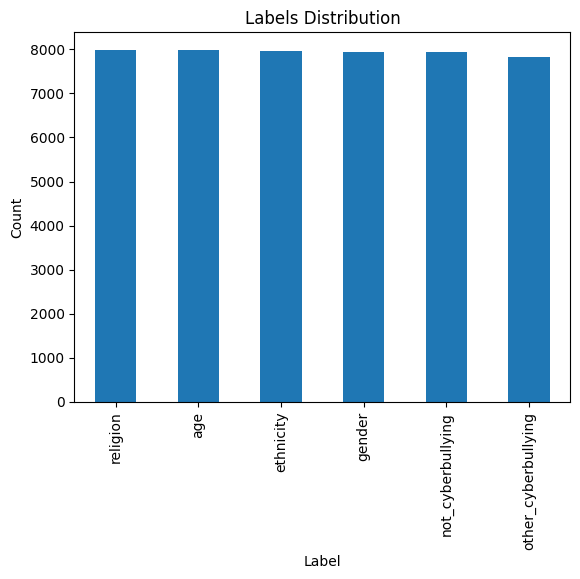

In [7]:
label_counts = df.cyberbullying_type.value_counts()

import matplotlib.pyplot as plt
plt.figure()
label_counts.plot(kind='bar')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Labels Distribution')
plt.show()


It can be seen that we have a very balanced distribution in our labels.



---



## Neural networks approach

Put to lowercase
Tokenize
Embeddings from GloVe or Word2Vec
Build the network

In [ ]:
from tokenizers import Tokenizer
from tokenizers.models import WordLevel, WordPiece
from tokenizers.trainers import WordLevelTrainer, WordPieceTrainer
from tokenizers.pre_tokenizers import Whitespace
from tokenizers import decoders
from tokenizers.normalizers import Lowercase

def create_tokenizer(tokenizer_type, vocab_size, dataframe, special_tokens) -> Tokenizer:
  if tokenizer_type == "wordpiece":
        model = WordPiece(unk_token="[UNK]")
        trainer = WordPieceTrainer(
            vocab_size=vocab_size,
            special_tokens=special_tokens
        )
  elif tokenizer_type == "wordlevel":
        model = WordLevel(unk_token="[UNK]")
        trainer = WordLevelTrainer(
            vocab_size=vocab_size,
            special_tokens=special_tokens
        )
  else:
      raise ValueError(f"Unknown tokenizer_type: {tokenizer_type}. Must be 'wordpiece' or 'wordlevel'")

  tokenizer = Tokenizer(model)
  tokenizer.normalizer = Lowercase()
  tokenizer.pre_tokenizer = Whitespace()


  tokenizer.train_from_iterator(iterator=dataframe, trainer=trainer)
  tokenizer.save("tokenizer.json")
  return tokenizer


In [ ]:
label_encodings = {"not_cyberbullying": 0, "religion" : 1, "age" : 2, "gender" : 3, "ethnicity" : 4, "other_cyberbullying" : 5 }
df['cyberbullying_type'] = df['cyberbullying_type'].map(label_encodings)


In [ ]:
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",0
1,Why is #aussietv so white? #MKR #theblock #ImA...,0
2,@XochitlSuckkks a classy whore? Or more red ve...,0
3,"@Jason_Gio meh. :P thanks for the heads up, b...",0
4,@RudhoeEnglish This is an ISIS account pretend...,0


In [ ]:
print(df['cyberbullying_type'].unique())

[0 3 1 5 2 4]


For the word_level_tokenizer I will get the embeddings from Glove model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import numpy as np
import os
glove_path = "/content/drive/MyDrive/glove.6B.100d.txt"
if not os.path.exists("/content/drive/MyDrive/glove.6B.100d.txt"):
    print("Downloading GloVe...")
    import requests, zipfile, io
    glove_url = "https://nlp.stanford.edu/data/glove.6B.zip"
    response = requests.get(glove_url)
    zip_file = zipfile.ZipFile(io.BytesIO(response.content))
    zip_file.extractall("glove_data")  # Extract once
    os.rename("glove_data/glove.6B.100d.txt", glove_path)  # Move to working dir
    print("Download complete!")
else:
    print("Loading from local file...")

# Load embeddings (works for both first and subsequent runs)
embeddings_index = {}
with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        word, *vector = line.split()
        embeddings_index[word] = np.array(vector, dtype=np.float32)

print(f"Loaded {len(embeddings_index)} word vectors.")

Loading from local file...
Loaded 400000 word vectors.


## Try with fastText

In [ ]:
"""import os
import requests
import gzip
import shutil
import gensim

# URL for the 100-dim English FastText vectors
url = "https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.100.vec.gz"
compressed_path = "cc.en.100.vec.gz"
extracted_path = "cc.en.100.vec"

# Download the compressed file if not present
if not os.path.exists(compressed_path):
    print("Downloading 100-dim FastText vectors (~1.5GB)...")
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(compressed_path, "wb") as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
    print("Download completed.")

# Extract the .vec file if not extracted yet
if not os.path.exists(extracted_path):
    print("Extracting the .vec file (this may take a few minutes)...")
    with gzip.open(compressed_path, "rb") as f_in, open(extracted_path, "wb") as f_out:
        shutil.copyfileobj(f_in, f_out)
    print("Extraction completed.")

# Load the vectors with gensim (this may take a few minutes)
print("Loading FastText vectors with gensim...")
fasttext = KeyedVectors.load_word2vec_format(extracted_path, binary=False)
print("Loaded vectors.")

# Example usage:
word = "happy"
if word in fasttext:
    print(f"Vector for '{word}': {fasttext[word][:10]}...")  # print first 10 dims
else:
    print(f"Word '{word}' not in vocabulary.")
"""

## ...

In [ ]:
sp_tokens = ["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"]
word_piece_tokenizer = create_tokenizer("wordpiece", 30000, df["tweet_text"], sp_tokens)
word_level_tokenizer = create_tokenizer("wordlevel", 25000, df["tweet_text"], sp_tokens)
print(word_level_tokenizer.encode("a testdsds sentence").tokens)
print(word_piece_tokenizer.encode("a testdsds sentence").tokens)

['a', '[UNK]', 'sentence']
['a', 'test', '##ds', '##ds', 'sentence']


Now let's try different models with the RNN based on word level tokenizer with GloVe and another based on word piece tokenizer, but first let's define a function which will be common for both

In [ ]:
import matplotlib.pyplot as plt
def plot_history(history):
  fig,ax = plt.subplots(1,2,figsize=(15,5))
  ax[0].plot(history.history['loss'])
  ax[0].plot(history.history['val_loss'])
  ax[0].set_title('Model Loss')
  ax[0].set_ylabel('Loss')
  ax[0].set_xlabel('Epoch')
  ax[0].legend(['Train', 'Validation'], loc='upper right')
  ax[1].plot(history.history['accuracy'])
  ax[1].plot(history.history['val_accuracy'])
  ax[1].set_title('Model Accuracy')
  ax[1].set_ylabel('Accuracy')
  ax[1].set_xlabel('Epoch')
  ax[1].legend(['Train', 'Validation'], loc='upper left')
  plt.show()

## LSTM with word level tokenizer and GloVe embeddings

In [ ]:
vocab = word_level_tokenizer.get_vocab()
vocab_size = len(vocab) + 1 #for padding token
print("Vocabulary size:", vocab_size)
embedding_dim = 100

# Build embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
word_index = {word: index for index, word in vocab.items()}
for i, word in word_index.items():
    if i < vocab_size:
        embedding_vector = embeddings_index.get(word.lower())
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

print("Embedding matrix shape:", embedding_matrix.shape)

Vocabulary size: 25001
Embedding matrix shape: (25001, 100)


In [ ]:
print(np.sum(embedding_matrix))  # Should be >> 0
print(np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1)))

-7553.781078510021
18494


In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training, validation and test sets
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42,shuffle = True)
validation_df, test_df = train_test_split(temp_df, test_size=1/3, random_state=42,shuffle = True)

In [ ]:
train_sequences = [word_level_tokenizer.encode(text).ids for text in train_df['tweet_text']]
validation_sequences = [word_level_tokenizer.encode(text).ids for text in validation_df['tweet_text']]

print("Max length of a sequence: ",max(len(seq) for seq in train_sequences))

NameError: name 'word_level_tokenizer' is not defined

1115 is a huge length for a sequence, so let's check if there is many sequences with length like that. Train df must be a good estimator for the validation and test df also, so I will check it only for train.

In [ ]:
train_df["sec_len"] = list(map(len,train_sequences))

In [ ]:
train_df['sec_len'][train_df['sec_len']>100].value_counts()

,count
sec_len,
384,1
1115,1
164,1
709,1
416,1
106,1
120,1
134,1
225,1


Not many at all. Everything above 100 an be considered outliers and we can restrict the max length of the padding this way, which will save a lot of time on training. We also do not need the new column anymore.

In [ ]:
train_df = train_df.drop("sec_len",axis = 1)

Now let's pad the sequences

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
padded_train_sequences = pad_sequences(train_sequences, maxlen=100, padding='post')
padded_validation_sequences = pad_sequences(validation_sequences, maxlen=100, padding='post')
padded_train_sequences[0]

array([    9, 21160,   404,   247,    31,     6,     0,    12,    22,
       23216,   186,   247,     5,    73,   604,    86,     6,   453,
          58,    44,    20,    12,    22,    55,    10,   168,   231,
          26,    95,  7933,   113,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0], dtype=int32)

Let's create a model and perform a small grid search

Epoch 1/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 42s 14ms/step - accuracy: 0.4854 - loss: 1.2221 - val_accuracy: 0.7959 - val_loss: 0.4792
Epoch 2/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.7971 - loss: 0.4908 - val_accuracy: 0.8303 - val_loss: 0.4129
Epoch 3/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.8539 - loss: 0.3685 - val_accuracy: 0.8443 - val_loss: 0.3972
Epoch 4/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.8923 - loss: 0.2924 - val_accuracy: 0.8383 - val_loss: 0.4215
Epoch 5/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.9106 - loss: 0.2463 - val_accuracy: 0.8378 - val_loss: 0.4653
Epoch 6/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.9226 - loss: 0.2088 - val_accuracy: 0.8288 - val_loss: 0.5252
Is trainable?  True Units:  16 dropout:  0.3


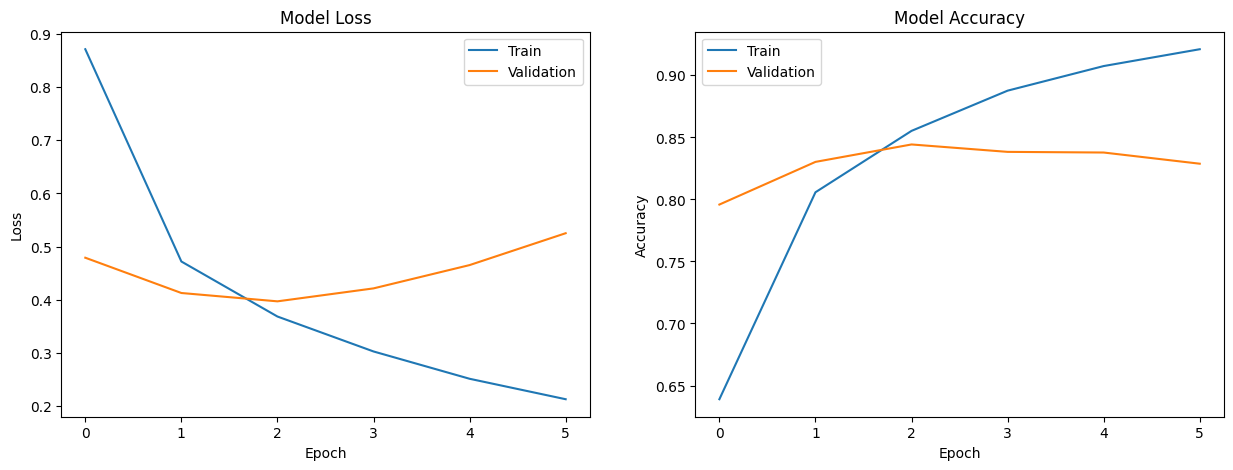

Epoch 1/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.4716 - loss: 1.2787 - val_accuracy: 0.7822 - val_loss: 0.5488
Epoch 2/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.7639 - loss: 0.5972 - val_accuracy: 0.7912 - val_loss: 0.5222
Epoch 3/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.7763 - loss: 0.5463 - val_accuracy: 0.8101 - val_loss: 0.4715
Epoch 4/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.7906 - loss: 0.5032 - val_accuracy: 0.8151 - val_loss: 0.4601
Epoch 5/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.8001 - loss: 0.4860 - val_accuracy: 0.8177 - val_loss: 0.4575
Epoch 6/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.8138 - loss: 0.4761 - val_accuracy: 0.8186 - val_loss: 0.4441
Epoch 7/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.8187 - loss: 0.4531 - val_accuracy: 0.8254 - val_loss: 0.4378
Epoch 8/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.8204 -

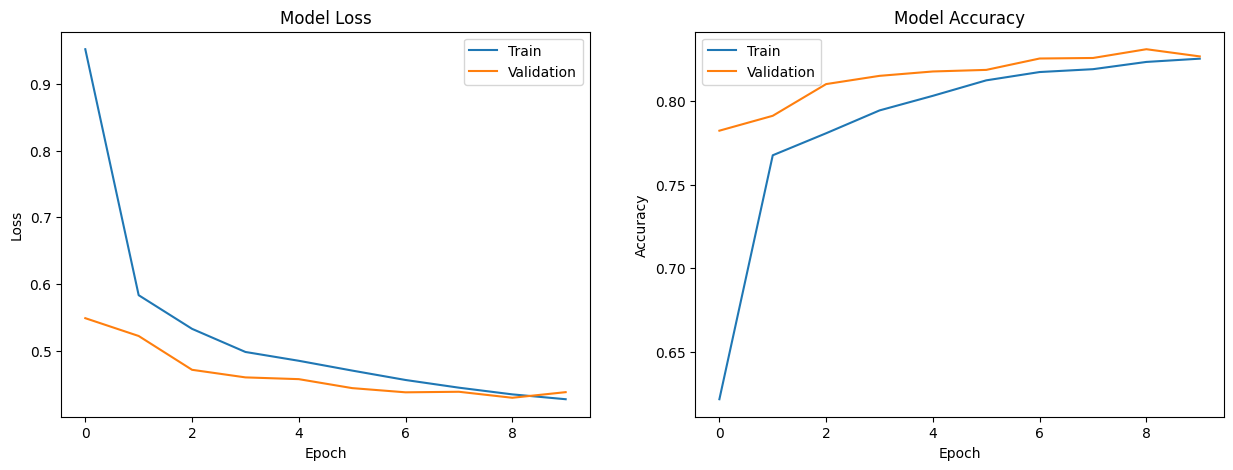

Epoch 1/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.4631 - loss: 1.2951 - val_accuracy: 0.7871 - val_loss: 0.4876
Epoch 2/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.7363 - loss: 0.6086 - val_accuracy: 0.8049 - val_loss: 0.4344
Epoch 3/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.7643 - loss: 0.5166 - val_accuracy: 0.8111 - val_loss: 0.4299
Epoch 4/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.7955 - loss: 0.4602 - val_accuracy: 0.8191 - val_loss: 0.4468
Epoch 5/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.8287 - loss: 0.4176 - val_accuracy: 0.8288 - val_loss: 0.4472
Epoch 6/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.8517 - loss: 0.3830 - val_accuracy: 0.8309 - val_loss: 0.4544
Is trainable?  True Units:  16 dropout:  0.5


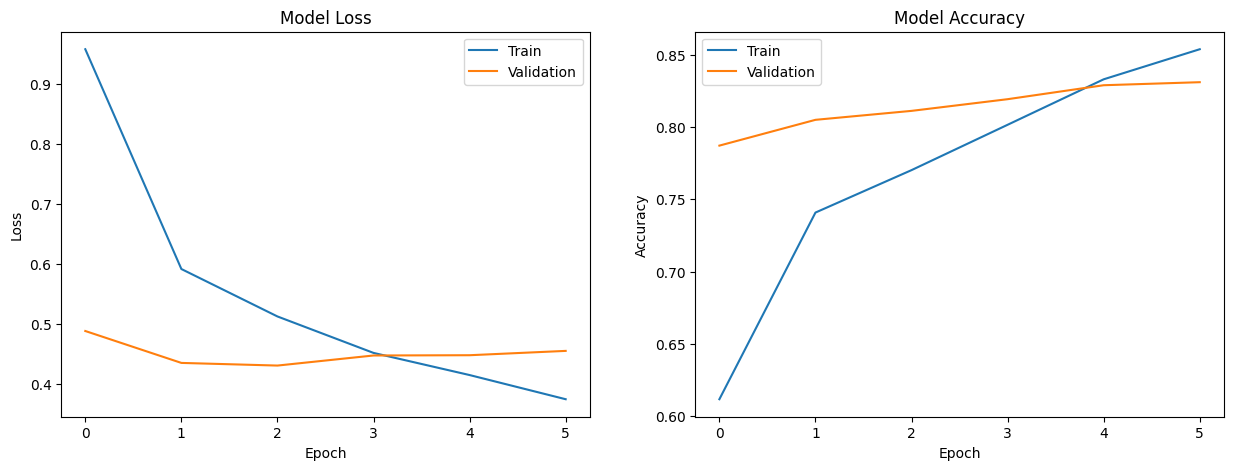

Epoch 1/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.4430 - loss: 1.3352 - val_accuracy: 0.7626 - val_loss: 0.5574
Epoch 2/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.7130 - loss: 0.6865 - val_accuracy: 0.7770 - val_loss: 0.5101
Epoch 3/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.7376 - loss: 0.6235 - val_accuracy: 0.7906 - val_loss: 0.4876
Epoch 4/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.7547 - loss: 0.5881 - val_accuracy: 0.8072 - val_loss: 0.4750
Epoch 5/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.7620 - loss: 0.5580 - val_accuracy: 0.8118 - val_loss: 0.4678
Epoch 6/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.7664 - loss: 0.5522 - val_accuracy: 0.8067 - val_loss: 0.4848
Epoch 7/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.7725 - loss: 0.5376 - val_accuracy: 0.8150 - val_loss: 0.4632
Epoch 8/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.7756 -

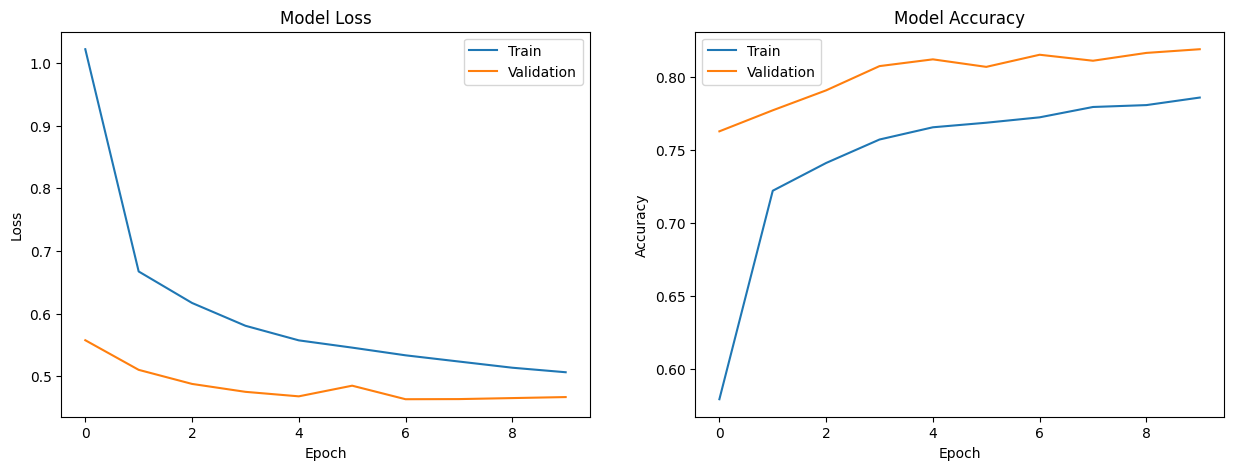

Epoch 1/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.5767 - loss: 1.0339 - val_accuracy: 0.8027 - val_loss: 0.4609
Epoch 2/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.8288 - loss: 0.4123 - val_accuracy: 0.8446 - val_loss: 0.3944
Epoch 3/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.8744 - loss: 0.3182 - val_accuracy: 0.8501 - val_loss: 0.3859
Epoch 4/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.9076 - loss: 0.2464 - val_accuracy: 0.8433 - val_loss: 0.4267
Epoch 5/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.9248 - loss: 0.2005 - val_accuracy: 0.8389 - val_loss: 0.4752
Epoch 6/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.9392 - loss: 0.1654 - val_accuracy: 0.8355 - val_loss: 0.5186
Is trainable?  True Units:  32 dropout:  0.3


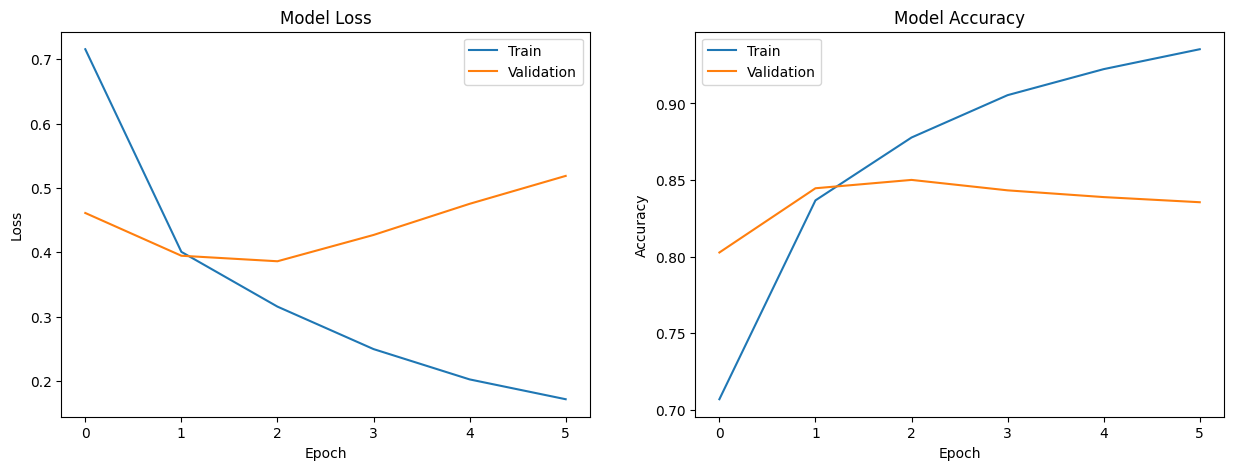

Epoch 1/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.5660 - loss: 1.0854 - val_accuracy: 0.7934 - val_loss: 0.5069
Epoch 2/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.7935 - loss: 0.5009 - val_accuracy: 0.8111 - val_loss: 0.4642
Epoch 3/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.8185 - loss: 0.4541 - val_accuracy: 0.8154 - val_loss: 0.4487
Epoch 4/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.8270 - loss: 0.4260 - val_accuracy: 0.8283 - val_loss: 0.4255
Epoch 5/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.8344 - loss: 0.4009 - val_accuracy: 0.8310 - val_loss: 0.4175
Epoch 6/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.8458 - loss: 0.3801 - val_accuracy: 0.8337 - val_loss: 0.4153
Epoch 7/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.8500 - loss: 0.3666 - val_accuracy: 0.8389 - val_loss: 0.4103
Epoch 8/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.8508 -

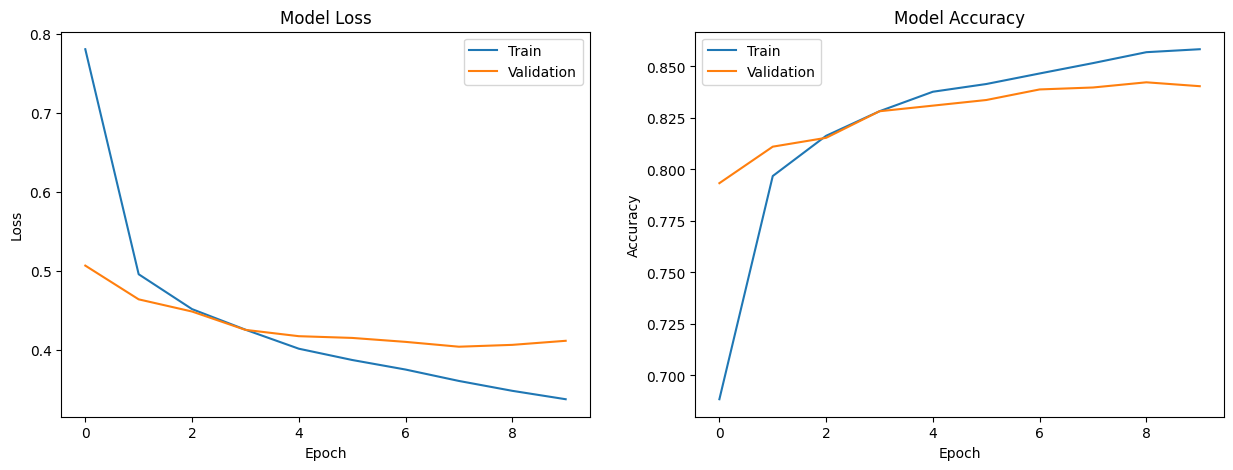

Epoch 1/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.5310 - loss: 1.1280 - val_accuracy: 0.8001 - val_loss: 0.4546
Epoch 2/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.8019 - loss: 0.4748 - val_accuracy: 0.8364 - val_loss: 0.3978
Epoch 3/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.8563 - loss: 0.3645 - val_accuracy: 0.8476 - val_loss: 0.3980
Epoch 4/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.8876 - loss: 0.2972 - val_accuracy: 0.8402 - val_loss: 0.4321
Epoch 5/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.9120 - loss: 0.2396 - val_accuracy: 0.8382 - val_loss: 0.4389
Is trainable?  True Units:  32 dropout:  0.5


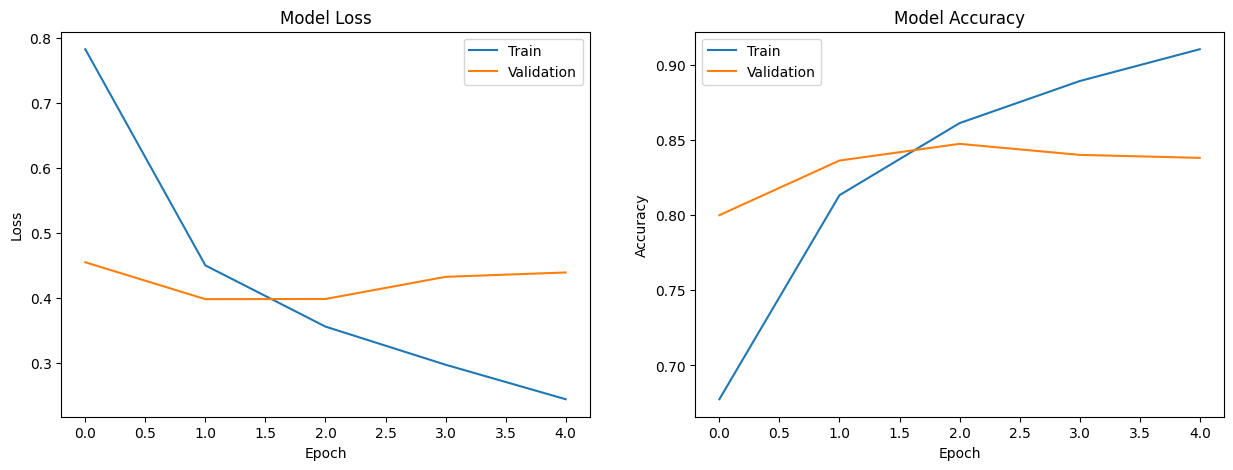

Epoch 1/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.5249 - loss: 1.1565 - val_accuracy: 0.7854 - val_loss: 0.5271
Epoch 2/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.7727 - loss: 0.5683 - val_accuracy: 0.8022 - val_loss: 0.4921
Epoch 3/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.7973 - loss: 0.5100 - val_accuracy: 0.8157 - val_loss: 0.4531
Epoch 4/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.8079 - loss: 0.4760 - val_accuracy: 0.8143 - val_loss: 0.4598
Epoch 5/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.8235 - loss: 0.4488 - val_accuracy: 0.8253 - val_loss: 0.4320
Epoch 6/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.8309 - loss: 0.4258 - val_accuracy: 0.8292 - val_loss: 0.4315
Epoch 7/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.8328 - loss: 0.4192 - val_accuracy: 0.8286 - val_loss: 0.4235
Epoch 8/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.8339 -

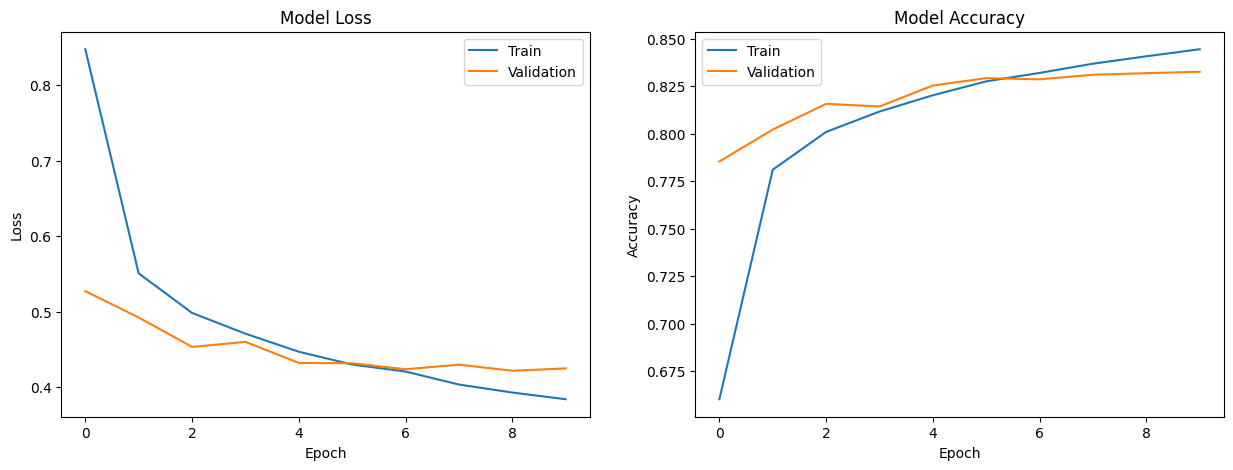

In [ ]:
import tensorflow as tf
dict_of_models = {}
for units in [16,32]:
  for dropout in [0.3, 0.5]:
    for trainable in [True, False]:
      model = tf.keras.Sequential([
        tf.keras.layers.Embedding(
              input_dim=vocab_size,
              output_dim=embedding_dim,
            weights = [embedding_matrix],
            trainable = trainable
              ),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units)),
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(6, activation='softmax')
      ])

      model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
      early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights = True)
      history = model.fit(padded_train_sequences, train_df['cyberbullying_type'], epochs=10, validation_data=(padded_validation_sequences, validation_df['cyberbullying_type']),callbacks = [early_stop])
      print("Is trainable? ", trainable, "Units: ", units, "dropout: ", dropout)
      plot_history(history)
      dict_of_models[history] = history.history["val_loss"]

In [ ]:
dict_of_models

{<keras.src.callbacks.history.History at 0x7ee9ae452410>: [0.4791681468486786,
  0.41286543011665344,
  0.39719876646995544,
  0.42154407501220703,
  0.46533724665641785,
  0.5252279043197632],
 <keras.src.callbacks.history.History at 0x7ee9fc91f310>: [0.5488442182540894,
  0.5221618413925171,
  0.4715085029602051,
  0.46014225482940674,
  0.4575057029724121,
  0.44406941533088684,
  0.43777239322662354,
  0.43860509991645813,
  0.4296053349971771,
  0.43801823258399963],
 <keras.src.callbacks.history.History at 0x7ee9fc690550>: [0.4876018762588501,
  0.43436363339424133,
  0.4299399256706238,
  0.4467522203922272,
  0.44719865918159485,
  0.4544214606285095],
 <keras.src.callbacks.history.History at 0x7ee9fbdcc090>: [0.5573544502258301,
  0.5100744366645813,
  0.48760268092155457,
  0.4749701917171478,
  0.4677719473838806,
  0.48477447032928467,
  0.4631698727607727,
  0.4633808434009552,
  0.46498674154281616,
  0.46660080552101135],
 <keras.src.callbacks.history.History at 0x7ee9e9

In [ ]:
model.save("lstm_model.keras")

Epoch 1/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - accuracy: 0.4964 - loss: 1.1812 - val_accuracy: 0.7854 - val_loss: 0.4885
Epoch 2/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - accuracy: 0.7841 - loss: 0.4920 - val_accuracy: 0.7956 - val_loss: 0.5142
Epoch 3/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 39s 19ms/step - accuracy: 0.8257 - loss: 0.4100 - val_accuracy: 0.8157 - val_loss: 0.4724
Epoch 4/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.8606 - loss: 0.3548 - val_accuracy: 0.8096 - val_loss: 0.5173
Epoch 5/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.8924 - loss: 0.2850 - val_accuracy: 0.8186 - val_loss: 0.5876
Epoch 6/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.9129 - loss: 0.2413 - val_accuracy: 0.8185 - val_loss: 0.6549


We can see that the model reaches it's best result almost immediately. Most probably it is impossible to reach the better result with this configuration.

In [ ]:
test_sequences = [tokenizer.encode(text).ids for text in df['tweet_text']]
padded_test_sequences = pad_sequences(test_sequences, maxlen=256, padding='post')

In [ ]:
preds = model.predict(padded_test_sequences)

1491/1491 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step


In [ ]:
accuracy = np.mean(np.argmax(preds, axis=1) == df['cyberbullying_type'])
accuracy

np.float64(0.8697475467583662)

In [ ]:
np.unique(np.argmax(preds, axis=1), return_counts = True)

(array([0, 1, 2, 3, 4, 5]), array([ 4754,  8057,  7895,  7826,  7920, 11240]))

## Transformer architecture approach

In [8]:
import datasets
from datasets import Dataset
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

model_name = "distilbert-base-uncased"
id2label = {0: "not_cyberbullying", 1 : "religion", 2 : "age", 3 : "gender", 4 : "ethnicity", 5 : "other_cyberbullying" }
label2id = {"not_cyberbullying": 0, "religion" : 1, "age" : 2, "gender" : 3, "ethnicity" : 4, "other_cyberbullying" : 5 }
model = DistilBertForSequenceClassification.from_pretrained(model_name,num_labels = 6, id2label = id2label, label2id = label2id)
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
def tokenize(batch):
    return tokenizer(batch["tweet_text"],max_length = 128, padding="max_length", truncation=True)
df_dataset = Dataset.from_pandas(df)
df_dataset = df_dataset.rename_column("cyberbullying_type", "labels")
df_dataset = df_dataset.cast_column("labels", datasets.features.ClassLabel(names=list(id2label.values()))) # Cast to ClassLabel
df_encoded = df_dataset.map(tokenize, batched = True, batch_size = None)

2025-06-10 19:43:45.160250: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749584625.634865      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749584625.752774      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Casting the dataset:   0%|          | 0/47656 [00:00<?, ? examples/s]

Map:   0%|          | 0/47656 [00:00<?, ? examples/s]

In [9]:
len(df_encoded[1]["input_ids"])

128

In [10]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [12]:
from sklearn.metrics import accuracy_score
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from transformers import ProgressCallback


def get_accuracy(preds):
  labels = preds.label_ids
  predictions = preds.predictions.argmax(axis = -1)
  accuracy = accuracy_score(labels, predictions)
  return {"accuracy": 0.95}  # Works


split_dataset = df_encoded.train_test_split(test_size=0.2, seed=42) # Added a seed for reproducibility
train_dataset = split_dataset['train']
eval_dataset = split_dataset['test']

train_args = TrainingArguments(output_dir = "./results" , eval_strategy = 'steps', eval_steps = 250,
                               per_device_train_batch_size = 16, per_device_eval_batch_size = 16,
                               learning_rate = 0.001,logging_dir = "./log", logging_strategy = "steps", save_strategy = "steps",
                               num_train_epochs = 3, load_best_model_at_end = True,  metric_for_best_model='accuracy',report_to='none', logging_steps=100, fp16=True,)
trainer  = Trainer(model = model,args = train_args,  train_dataset = train_dataset, eval_dataset= eval_dataset, compute_metrics = get_accuracy, tokenizer = tokenizer)
trainer.add_callback(ProgressCallback())
trainer.train()



/tmp/ipykernel_35/3345628379.py:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer  = Trainer(model = model,args = train_args,  train_dataset = train_dataset, eval_dataset= eval_dataset, compute_metrics = get_accuracy, tokenizer = tokenizer)


  0%|          | 0/3576 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
250,1.802600,1.825074,0.950000
500,1.792900,1.794792,0.950000
750,1.794100,1.793099,0.950000
1000,1.793200,1.791586,0.950000
1250,1.792000,1.792165,0.950000
1500,1.794700,1.791569,0.950000
1750,1.792100,1.793081,0.950000
2000,1.791900,1.791703,0.950000
2250,1.791800,1.791838,0.950000
2500,1.791800,1.791906,0.950000


{'loss': 1.7958, 'grad_norm': 81182.2109375, 'learning_rate': 0.0009723154362416108, 'epoch': 0.08}
{'loss': 1.8026, 'grad_norm': 311363.3125, 'learning_rate': 0.000944351230425056, 'epoch': 0.17}


  0%|          | 0/298 [00:00<?, ?it/s]

{'eval_loss': 1.8250741958618164, 'eval_accuracy': 0.95, 'eval_runtime': 23.4871, 'eval_samples_per_second': 405.839, 'eval_steps_per_second': 12.688, 'epoch': 0.21}


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 1.7997, 'grad_norm': 16820.85546875, 'learning_rate': 0.0009163870246085011, 'epoch': 0.25}
{'loss': 1.7941, 'grad_norm': 12608.16015625, 'learning_rate': 0.0008884228187919463, 'epoch': 0.34}
{'loss': 1.7929, 'grad_norm': 25375.3359375, 'learning_rate': 0.0008604586129753915, 'epoch': 0.42}


  0%|          | 0/298 [00:00<?, ?it/s]

{'eval_loss': 1.7947919368743896, 'eval_accuracy': 0.95, 'eval_runtime': 23.5638, 'eval_samples_per_second': 404.519, 'eval_steps_per_second': 12.647, 'epoch': 0.42}


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 1.794, 'grad_norm': 16564.6796875, 'learning_rate': 0.0008324944071588367, 'epoch': 0.5}
{'loss': 1.7941, 'grad_norm': 12909.208984375, 'learning_rate': 0.000804530201342282, 'epoch': 0.59}


  0%|          | 0/298 [00:00<?, ?it/s]

{'eval_loss': 1.7930986881256104, 'eval_accuracy': 0.95, 'eval_runtime': 23.9788, 'eval_samples_per_second': 397.518, 'eval_steps_per_second': 12.428, 'epoch': 0.63}


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 1.7938, 'grad_norm': 6811.56494140625, 'learning_rate': 0.0007765659955257271, 'epoch': 0.67}
{'loss': 1.7921, 'grad_norm': 22532.51953125, 'learning_rate': 0.0007486017897091723, 'epoch': 0.76}
{'loss': 1.7932, 'grad_norm': 19460.611328125, 'learning_rate': 0.0007206375838926175, 'epoch': 0.84}


  0%|          | 0/298 [00:00<?, ?it/s]

{'eval_loss': 1.7915860414505005, 'eval_accuracy': 0.95, 'eval_runtime': 23.6012, 'eval_samples_per_second': 403.877, 'eval_steps_per_second': 12.626, 'epoch': 0.84}


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 1.793, 'grad_norm': 5904.10205078125, 'learning_rate': 0.0006926733780760626, 'epoch': 0.92}
{'loss': 1.792, 'grad_norm': 8886.095703125, 'learning_rate': 0.0006647091722595079, 'epoch': 1.01}


  0%|          | 0/298 [00:00<?, ?it/s]

{'eval_loss': 1.792164921760559, 'eval_accuracy': 0.95, 'eval_runtime': 23.2942, 'eval_samples_per_second': 409.2, 'eval_steps_per_second': 12.793, 'epoch': 1.05}


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 1.7923, 'grad_norm': 27820.630859375, 'learning_rate': 0.000636744966442953, 'epoch': 1.09}
{'loss': 1.7927, 'grad_norm': 30918.626953125, 'learning_rate': 0.0006087807606263982, 'epoch': 1.17}
{'loss': 1.7947, 'grad_norm': 11823.1484375, 'learning_rate': 0.0005808165548098434, 'epoch': 1.26}


  0%|          | 0/298 [00:00<?, ?it/s]

{'eval_loss': 1.7915688753128052, 'eval_accuracy': 0.95, 'eval_runtime': 23.437, 'eval_samples_per_second': 406.707, 'eval_steps_per_second': 12.715, 'epoch': 1.26}


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 1.7921, 'grad_norm': 14161.5009765625, 'learning_rate': 0.0005528523489932886, 'epoch': 1.34}
{'loss': 1.7921, 'grad_norm': 12276.197265625, 'learning_rate': 0.0005248881431767339, 'epoch': 1.43}


  0%|          | 0/298 [00:00<?, ?it/s]

{'eval_loss': 1.7930814027786255, 'eval_accuracy': 0.95, 'eval_runtime': 23.4324, 'eval_samples_per_second': 406.787, 'eval_steps_per_second': 12.717, 'epoch': 1.47}


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 1.7922, 'grad_norm': 18794.685546875, 'learning_rate': 0.000496923937360179, 'epoch': 1.51}
{'loss': 1.7923, 'grad_norm': 6362.5380859375, 'learning_rate': 0.00046895973154362415, 'epoch': 1.59}
{'loss': 1.7919, 'grad_norm': 3666.74169921875, 'learning_rate': 0.00044099552572706937, 'epoch': 1.68}


  0%|          | 0/298 [00:00<?, ?it/s]

{'eval_loss': 1.7917028665542603, 'eval_accuracy': 0.95, 'eval_runtime': 23.3255, 'eval_samples_per_second': 408.651, 'eval_steps_per_second': 12.776, 'epoch': 1.68}


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 1.7918, 'grad_norm': 8936.40234375, 'learning_rate': 0.0004130313199105146, 'epoch': 1.76}
{'loss': 1.7918, 'grad_norm': 12530.7392578125, 'learning_rate': 0.0003850671140939597, 'epoch': 1.85}


  0%|          | 0/298 [00:00<?, ?it/s]

{'eval_loss': 1.79183828830719, 'eval_accuracy': 0.95, 'eval_runtime': 23.3717, 'eval_samples_per_second': 407.844, 'eval_steps_per_second': 12.75, 'epoch': 1.89}


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 1.7917, 'grad_norm': 8088.40966796875, 'learning_rate': 0.00035710290827740493, 'epoch': 1.93}
{'loss': 1.7918, 'grad_norm': 13353.1572265625, 'learning_rate': 0.0003291387024608501, 'epoch': 2.01}
{'loss': 1.7918, 'grad_norm': 10758.6533203125, 'learning_rate': 0.0003011744966442953, 'epoch': 2.1}


  0%|          | 0/298 [00:00<?, ?it/s]

{'eval_loss': 1.7919057607650757, 'eval_accuracy': 0.95, 'eval_runtime': 23.494, 'eval_samples_per_second': 405.72, 'eval_steps_per_second': 12.684, 'epoch': 2.1}


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 1.7919, 'grad_norm': 10394.8740234375, 'learning_rate': 0.0002732102908277405, 'epoch': 2.18}
{'loss': 1.7917, 'grad_norm': 9011.5546875, 'learning_rate': 0.0002452460850111857, 'epoch': 2.27}


  0%|          | 0/298 [00:00<?, ?it/s]

{'eval_loss': 1.7918905019760132, 'eval_accuracy': 0.95, 'eval_runtime': 23.4146, 'eval_samples_per_second': 407.096, 'eval_steps_per_second': 12.727, 'epoch': 2.31}


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 1.7917, 'grad_norm': 7457.01123046875, 'learning_rate': 0.00021728187919463089, 'epoch': 2.35}
{'loss': 1.7919, 'grad_norm': 6933.642578125, 'learning_rate': 0.00018931767337807605, 'epoch': 2.43}
{'loss': 1.7919, 'grad_norm': 16358.763671875, 'learning_rate': 0.00016135346756152125, 'epoch': 2.52}


  0%|          | 0/298 [00:00<?, ?it/s]

{'eval_loss': 1.791868805885315, 'eval_accuracy': 0.95, 'eval_runtime': 23.2893, 'eval_samples_per_second': 409.287, 'eval_steps_per_second': 12.796, 'epoch': 2.52}


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 1.7918, 'grad_norm': 6364.9375, 'learning_rate': 0.00013338926174496645, 'epoch': 2.6}
{'loss': 1.7915, 'grad_norm': 5458.88671875, 'learning_rate': 0.00010542505592841163, 'epoch': 2.68}


  0%|          | 0/298 [00:00<?, ?it/s]

{'eval_loss': 1.7918641567230225, 'eval_accuracy': 0.95, 'eval_runtime': 23.6928, 'eval_samples_per_second': 402.316, 'eval_steps_per_second': 12.578, 'epoch': 2.73}


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 1.7917, 'grad_norm': 6895.38427734375, 'learning_rate': 7.746085011185683e-05, 'epoch': 2.77}
{'loss': 1.7917, 'grad_norm': 6166.3359375, 'learning_rate': 4.9496644295302015e-05, 'epoch': 2.85}
{'loss': 1.7918, 'grad_norm': 3683.136962890625, 'learning_rate': 2.1532438478747204e-05, 'epoch': 2.94}


  0%|          | 0/298 [00:00<?, ?it/s]

{'eval_loss': 1.7918672561645508, 'eval_accuracy': 0.95, 'eval_runtime': 23.4187, 'eval_samples_per_second': 407.026, 'eval_steps_per_second': 12.725, 'epoch': 2.94}


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'train_runtime': 1191.5833, 'train_samples_per_second': 95.983, 'train_steps_per_second': 3.001, 'train_loss': 1.7929460751663653, 'epoch': 3.0}


TrainOutput(global_step=3576, training_loss=1.7929460751663653, metrics={'train_runtime': 1191.5833, 'train_samples_per_second': 95.983, 'train_steps_per_second': 3.001, 'total_flos': 3787910518523904.0, 'train_loss': 1.7929460751663653, 'epoch': 3.0})

In [17]:
for log in trainer.state.log_history:
    print(log)

{'eval_model_preparation_time': 0.0017, 'eval_runtime': 1757.8849, 'eval_samples_per_second': 5.422, 'eval_steps_per_second': 0.339, 'step': 0}


In [ ]:
pip install wandb


In [13]:
trainer.save_model()
trainer.evaluate()

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


  0%|          | 0/298 [00:00<?, ?it/s]

{'eval_loss': 1.7918678522109985,
 'eval_accuracy': 0.95,
 'eval_runtime': 24.0815,
 'eval_samples_per_second': 395.822,
 'eval_steps_per_second': 12.375,
 'epoch': 3.0}